# Cycle Fucking Gan

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from losses import discriminator_loss, generator_loss, calc_cycle_loss, identity_loss
from generator import Generator
from discriminator import Discriminator
from data_generator import load_dataset
from cycleGAN import CycleGAN
import matplotlib.pyplot as plt
import re
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

gpu = len(tf.config.list_physical_devices('GPU'))>0

if gpu:
    print("GPU is", "available")
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("NOT AVAILABLE")
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available


In [2]:
GANDIDO_FILENAMES = tf.io.gfile.glob('gandido/*.jpeg')
print('Gandido Files:', len(GANDIDO_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo/*.jpeg')
print('Photo Files:', len(PHOTO_FILENAMES))

Gandido Files: 4580
Photo Files: 7038


In [3]:
IMAGE_SIZE = [200,200]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32)/127.5) - 1
    
    image = tf.image.resize(image, IMAGE_SIZE,
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = tf.reshape(image, [*IMAGE_SIZE,3])

    return image

def process(example):
    img = tf.io.read_file(example)

    image = decode_image(img)
    return image

In [4]:
def load_dataset(img_path, labeled=True, ordered=False):
    dataset = tf.data.Dataset.list_files(img_path)
    dataset = dataset.map(lambda x: process(x))
    return dataset

In [5]:
filename_dataset = tf.data.Dataset.list_files("./gandido/*.jpeg")

In [12]:
filename_dataset = filename_dataset.map(lambda x: process(x))

In [14]:
candido_datagen = tf.data.Dataset.list_files("./gandido/*.jpeg")
photo_datagen = tf.data.Dataset.list_files("./photo/*.jpeg")


candido_ds = candido_datagen.map(lambda x: process(x))

photo_ds = photo_datagen.map(lambda x: process(x))

SyntaxError: invalid syntax (<ipython-input-14-d9fe04ca6e20>, line 10)

In [19]:
example_candido = next(iter(candido_ds))
example_photo = next(iter(photo_ds))

In [20]:
example_candido

<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
array([[[-0.8666667 , -0.85882354, -0.8980392 ],
        [-0.8509804 , -0.84313726, -0.88235295],
        [-0.8509804 , -0.84313726, -0.88235295],
        ...,
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ]],

       [[-0.8745098 , -0.8666667 , -0.90588236],
        [-0.85882354, -0.8509804 , -0.8901961 ],
        [-0.8509804 , -0.84313726, -0.88235295],
        ...,
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ]],

       [[-0.8745098 , -0.8666667 , -0.90588236],
        [-0.85882354, -0.8509804 , -0.8901961 ],
        [-0.8509804 , -0.84313726, -0.88235295],
        ...,
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ],
        [-0.94509804, -0.92941177, -0.9529412 ]],

       ...,

     

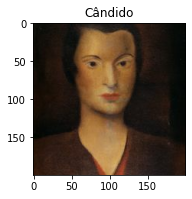

In [22]:
#plt.subplot(121)
#plt.title('Photo')
#plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Cândido')
plt.imshow(example_candido* 0.5 + 0.5)

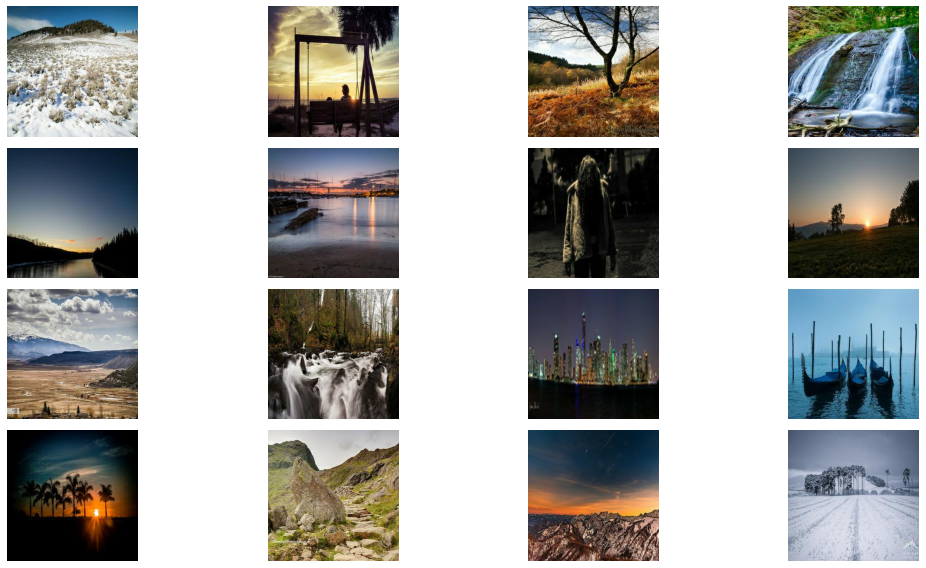

In [9]:
display_multiple_img(PHOTO_FILENAMES, 4, 4)